# Classification ~ *The Sequel*
The goal of this attempt is to classify cases into two buckets, cases in which the defendant plead guilty or was found guilty and cases in which the defendant was found not guilty. The data split is done easily by checking the disposition name, 'convicted' for guilty cases and 'acquitted' for not guilty cases.

This time, I will not attempt to extract features, I will simply give the data 'as is'. Extracting features from the date columns entails converting one date column into three columns, the day, month, and year.

## Outcomes
It could help identify individuals that commited the crime that they are in court for or whether a person is being falsely accused.

## Technical Aspects
This is a binary classification problem which avoids the overhead of `ovo` or `ova` solutions to multiclassification however we still have to clean the data.

We will use the sklearn classification report to gauge the accuracy of the models, specifically because of the recall.

### Pre-processing
Our data consists of `../data/_baked/cases_recorded.csv` and helper tables in `../data/keys/`.

Before we can train models, we have to prepare the data. This is done with,

* merging with judge details
* dropping columns and rows with missing or conflicting data and working with dates
* one hot encoding non numerical data with no inherent order like purpose_name
* transforming numerical columns to have the same weight

In [1]:
import pandas as pd

In [3]:
CHUNK_SIZE = 100_000

In [5]:
%%time
# decision judge with case id
judge_case_df = pd.read_csv('../data/keys/judge_case_merge_key.csv')
judge_case_df.drop(['ddl_filing_judge_id'], axis=1, inplace=True)

# rename column
judge_case_cols = list(judge_case_df.columns)
judge_case_cols[1] = 'ddl_judge_id'
judge_case_df.columns = judge_case_cols

# judges df
judges_df = pd.read_csv('../data/judges_clean.csv')
judges_df = judges_df[['ddl_judge_id', 'female_judge']]

# merge the two dfs
judge_data_df = pd.merge(judge_case_df, judges_df, on='ddl_judge_id', how='inner')

CPU times: total: 10.1 s
Wall time: 10.2 s


In [6]:
judge_data_df

,ddl_case_id,ddl_judge_id,female_judge
0,01-01-01-201900000022018,5.0,0 nonfemale
1,01-01-01-201900000032017,5.0,0 nonfemale
2,01-01-01-201900000042016,5.0,0 nonfemale
3,01-01-01-201900000052018,5.0,0 nonfemale
4,01-01-01-201900000072016,5.0,0 nonfemale
...,...,...,...
12290700,30-02-05-204000000162014,98405.0,1 female
12290701,30-02-06-201400000682011,98452.0,0 nonfemale
12290702,30-02-06-201400000992011,98452.0,0 nonfemale
12290703,30-02-06-201400001092011,98452.0,0 nonfemale


In [23]:
dispositions_df = pd.read_csv('../data/keys/disp_name_key.csv')

In [28]:
%%time
# in this cell we bake our data to extract features
cases_df = pd.read_csv('../data/_baked/cases_recorded.csv',
                iterator=True,
                chunksize=CHUNK_SIZE,
                low_memory=False)

chunk = 1
for df in cases_df:
    # PART1: merging to obtain decision judge gender
    df = pd.merge(df, judge_data_df, on='ddl_case_id', how='inner')

    # PART2: working with irrelevant columns
    df.drop(['bailable_ipc', 'dist_code', 'ddl_case_id', 'section',
             'cino', 'ddl_judge_id', 'number_sections_ipc', 'act',
             'female_adv_pet', 'female_adv_def', 'female_petitioner',
             'year', 'purpose_name'
            ], axis=1, inplace=True)
    
    # PART3: working with dates
    date_columns = ['date_of_decision', 'date_of_filing', 'date_first_list', 'date_last_list', 'date_next_list']
    # parse date columns as dates
    for date_col in date_columns:
        df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True, errors='coerce')

    # drop rows whose dates could not be parsed
    df.dropna(subset=date_columns, inplace=True)

    # extract data
    for date_col in date_columns:
        df[f'{date_col}_year'] = df[date_col].dt.year
        df[f'{date_col}_month'] = df[date_col].dt.month
        df[f'{date_col}_day'] = df[date_col].dt.day

    # delete original date columns
    df.drop(date_columns, axis=1, inplace=True)

    # PART4: working with gender columns
    gender_columns = ['female_judge', 'female_defendant']
    # filter out unclear genders
    for gender_col in gender_columns:
        # filter on valid data
        df[gender_col] = df[gender_col].astype(str).transform(lambda gen: gen[0])
        gender_valid_filt = (df[gender_col] == '0') | (df[gender_col] == '1')
        df = df[gender_valid_filt]

        # convert to numeric column
        df[gender_col] = pd.to_numeric(df[gender_col])
    
    # PART5: we now filter to get cases in which the disposition is
    # acquitted or convicted
    df = pd.merge(df, dispositions_df, on='disp_name', how='inner')
    interested_in_filt = (df['disp_name_s'] == 'acquitted') | (df['disp_name_s'] == 'convicted')
    df = df[interested_in_filt]
    
    df.drop(['disp_name'], axis=1, inplace=True)
    
    # write df_acts_sections to a data file
    df.to_csv('../data/_baked/ml/convicted_acquitted.csv',
              header=(chunk == 1),
              mode='a',
              index=False)

    print('.', end='')
    chunk += 1

print('Done.')

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Done.
CPU times: total: 1h 54min 56s
Wall time: 1h 55min 9s


### Cleaning Categorical Values
We have 8 million rows to work with, but the categorical data present in columns `judge_position`, `court_no`, `type_name` have too many values, so we drop some values that appear less often.

This sacrifices some amount of data but allows us to One Hot Encode these columns which might be useful for the models.

We take the top 20 used values.

> ps: I dropped `year` and `count` aswell

In [29]:
data_df = pd.read_csv('../data/_baked/ml/convicted_acquitted.csv')

In [ ]:
data_df.drop(['year', 'count'], axis=1, inplace=True)

In [46]:
data_df.columns

Index(['state_code', 'court_no', 'judge_position', 'female_defendant',
       'type_name', 'criminal', 'female_judge', 'date_of_decision_year',
       'date_of_decision_month', 'date_of_decision_day', 'date_of_filing_year',
       'date_of_filing_month', 'date_of_filing_day', 'date_first_list_year',
       'date_first_list_month', 'date_first_list_day', 'date_last_list_year',
       'date_last_list_month', 'date_last_list_day', 'date_next_list_year',
       'date_next_list_month', 'date_next_list_day', 'disp_name_s'],
      dtype='object')

In [47]:
categorical_cols = ['court_no', 'judge_position', 'type_name']

In [58]:
for column in categorical_cols:
    vc_df = data_df[column].value_counts()
    valid_values = list(vc_df.iloc[:20].index)

    filt = data_df[column].isin(valid_values)
    data_df = data_df[filt]

In [64]:
data_df['disp_name_s'].value_counts()

acquitted    2444265
convicted     375201
Name: disp_name_s, dtype: int64

### One Hot Encoding

In [65]:
from sklearn.preprocessing import OneHotEncoder

In [66]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

categorical_cols_df = data_df[categorical_cols]
numerical_df = data_df.drop(categorical_cols, axis=1)

OH_categorical_cols_df = pd.DataFrame(OH_encoder.fit_transform(categorical_cols_df))
OH_categorical_cols_df.index = categorical_cols_df.index

processed_df = pd.concat([OH_categorical_cols_df, numerical_df], axis=1)

### Creating `y`
* `y = 1` for convicted
* `y = 0` for acquitted

In [69]:
processed_df['y'] = processed_df['disp_name_s'].transform(lambda disp_s: 1 if disp_s == 'convicted' else 0)

In [71]:
processed_df.drop(['disp_name_s'], axis=1, inplace=True)

### Store Data
The complete data is stored, this csv file represents the dataset that will be used to train the models.

In [73]:
%%time
processed_df.to_csv('../data/_baked/ml/convicted_acquitted_processed.csv', index=False)

CPU times: total: 1min 9s
Wall time: 1min 9s


In [74]:
processed_df.shape

(2819466, 80)

### Data Split
We create a data split and visualize the data we have.

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
processed_df = pd.read_csv('../data/_baked/ml/convicted_acquitted_processed.csv')
X = processed_df.drop(['y'], axis=1)
y = processed_df['y']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

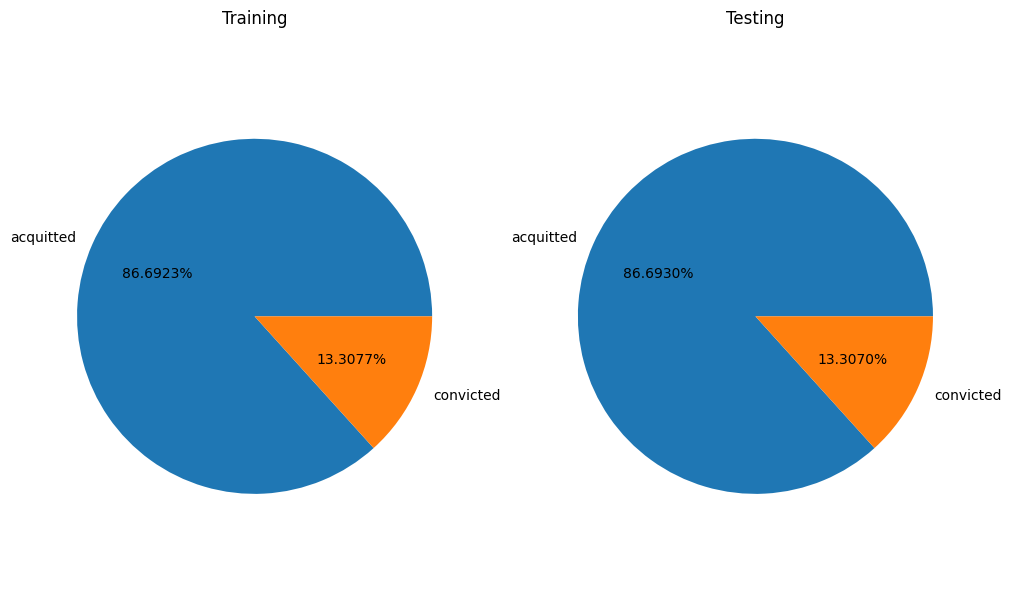

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)

for dname, dset, ax in zip(['Training', 'Testing'], [y_train, y_test], axs.flat):
    n_acquitted = dset.value_counts()[0]
    n_convicted = dset.value_counts()[1]
    total = n_convicted + n_acquitted

    p_acquitted = n_acquitted / total * 100
    p_convicted = n_convicted / total * 100

    labels = ['acquitted', 'convicted']
    p = [p_acquitted, p_convicted]

    ax.set_title(dname)
    ax.pie(p, labels=labels, autopct='%1.4f%%')
    ax.axis('equal')

plt.show()

## Training Models
We have finished pre-processing and cleaning data, this data is now fit to be fed into a machine learning model.

We train the following models,
* SGDClassifer
* RandomForestClassifier

### SGDClassifer
#### Results
Having a non-zero f1-score is definitely a nice to see, this indicated that the model has some rudimentary learning and could perhaps better on a more powerful model.

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

In [12]:
sgd_clf.fit(X_train.values, y_train.values)

C:\Users\vnnm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(random_state=42)

In [13]:
y_test_pred = sgd_clf.predict(X_test.values)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test.values, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93    733284
           1       0.86      0.06      0.11    112556

    accuracy                           0.87    845840
   macro avg       0.87      0.53      0.52    845840
weighted avg       0.87      0.87      0.82    845840



### RandomForest Classifer
#### Results
A high degree of learning is displayed here, `cross_val_score` here is nearly 99%. The f1-score being 1 for `acquitted` cases indicates the model never guessed wrong about when a defendant is not guilty. The f1-score for `convicted` is 0.98 which is incredibly high and can thus be used to help ascertain whether a defendant is guilty or not.

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

In [7]:
%%time
rf_clf.fit(X_train.values, y_train.values)

CPU times: total: 7min 42s
Wall time: 7min 44s


RandomForestClassifier(random_state=42)

In [15]:
y_test_pred = rf_clf.predict(X_test.values)
print(classification_report(y_test.values, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    733284
           1       0.99      0.97      0.98    112556

    accuracy                           1.00    845840
   macro avg       0.99      0.98      0.99    845840
weighted avg       1.00      1.00      1.00    845840



In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf_clf, X_train.values, y_train.values, cv=3, scoring="accuracy")

array([0.98968803, 0.98978833, 0.98967737])

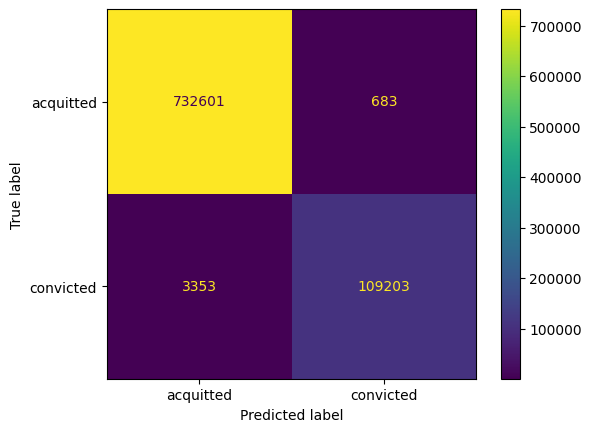

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.values, y_test_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acquitted', 'convicted'])

cm_display.plot()
plt.show()

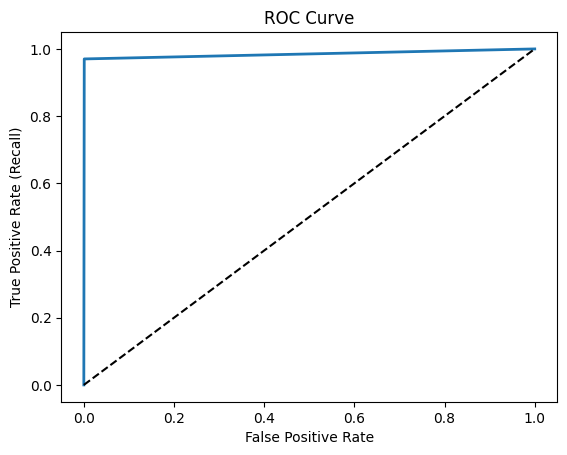

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test.values, y_test_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.values, y_test_pred)

0.9846394789341884

## Conclusion
Thus, we have trained an incredibly accurate model to ascertain whether a defendant would be found guilty or not based on case metadata.

We reached an incredibly high accuracy with the RandomForestClassifer and so no other models are tested, however if we wish to tweak accuracy further we could use deep learning with `keras` or `pytorch` or extreme gradient boosting with `xgboost`.

## Insights
* There is strong interdependence between case metadata and the verdict of the case (evident from model accuracy).
* We could deploy the model in court to speed up decision making.
* Judges could use this to help make a decision when the evidence is unclear or non-existent.
* The police can identify patterns in `acquitted` and `convicted` cases to identify regions of high crime rate or times during the years when the force should be strengthened for heightened crime.

## Recreating
These results take quite some time to recreate, for ease of use I have dumped the RandomForestClassifer into `../models/convicted_acquitted_rfc.sav` and the code to load the model is below.

In [16]:
import pickle

In [37]:
%%time
# save the model to disk
file_path = '../models/convicted_acquitted_rfc.sav'
pickle.dump(rf_clf, open(file_path, 'wb'))

CPU times: total: 1.02 s
Wall time: 1.08 s


In [ ]:
# instructions to load the model
rf_clf = pickle.load(open(file_path, 'rb'))